<a href="https://colab.research.google.com/github/syahputra21/Deep_Learning_Tugas-2_Klasifikasi-Pisau/blob/main/Deep_Learning_Tugas2_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path ke dataset di Google Drive
dataset_path = '/content/drive/MyDrive/Dataset_Pisau'  # Ganti dengan path dataset Anda

# Parameter model
IMG_SIZE = (224, 224)  # Ukuran input EfficientNetB0
BATCH_SIZE = 32
EPOCHS = 50  # 50 epoch tanpa early stopping
NUM_CLASSES = 4  # Karena ada 4 kelas

# Path untuk menyimpan model terbaik
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, 'efficientnet_model_50epoch_no_earlystopping.h5')

In [3]:
# Augmentasi data untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Hanya rescale untuk data validasi dan testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk data validasi
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk data testing
test_generator = val_test_datagen.flow_from_directory(
    dataset_path,  # Ganti dengan path test set jika terpisah
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Menampilkan kelas dan indeksnya
print("Kelas yang terdeteksi:", train_generator.class_indices)

Found 968 images belonging to 4 classes.
Found 242 images belonging to 4 classes.
Found 1210 images belonging to 4 classes.
Kelas yang terdeteksi: {'Cutter': 0, 'Pen_Cutter': 1, 'Pisau Dapur': 2, 'Pisau_Daging': 3}


In [4]:
# Membuat base model EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Membangun model custom di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layer base model untuk transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce learning rate ketika val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, reduce_lr]  # Hanya menggunakan ModelCheckpoint dan ReduceLROnPlateau

In [6]:
# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,  # Akan berjalan 50 epoch penuh
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2648 - loss: 1.6282
Epoch 1: val_accuracy improved from -inf to 0.27679, saving model to /content/drive/MyDrive/saved_models/efficientnet_model_50epoch_no_earlystopping.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - accuracy: 0.2646 - loss: 1.6261 - val_accuracy: 0.2768 - val_loss: 1.3910 - learning_rate: 0.0010
Epoch 2/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2188 - loss: 1.4254

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.27679
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.2188 - loss: 1.4254 - val_accuracy: 0.2768 - val_loss: 1.3971 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.2462 - loss: 1.4114
Epoch 3: val_accuracy did not improve from 0.27679
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 779ms/step - accuracy: 0.2456 - loss: 1.4116 - val_accuracy: 0.1875 - val_loss: 1.3939 - learning_rate: 0.0010
Epoch 4/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1250 - loss: 1.4066
Epoch 4: val_accuracy did not improve from 0.27679
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.1250 - loss: 1.4066 - val_accuracy: 0.2768 - val_loss: 1.3820 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.2529 - loss: 1.4154
Epoch 5: val_accuracy did not improve from 0.27679
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2524 - loss: 1.4152 - val_accuracy: 0.2768 - val_loss: 1.3879

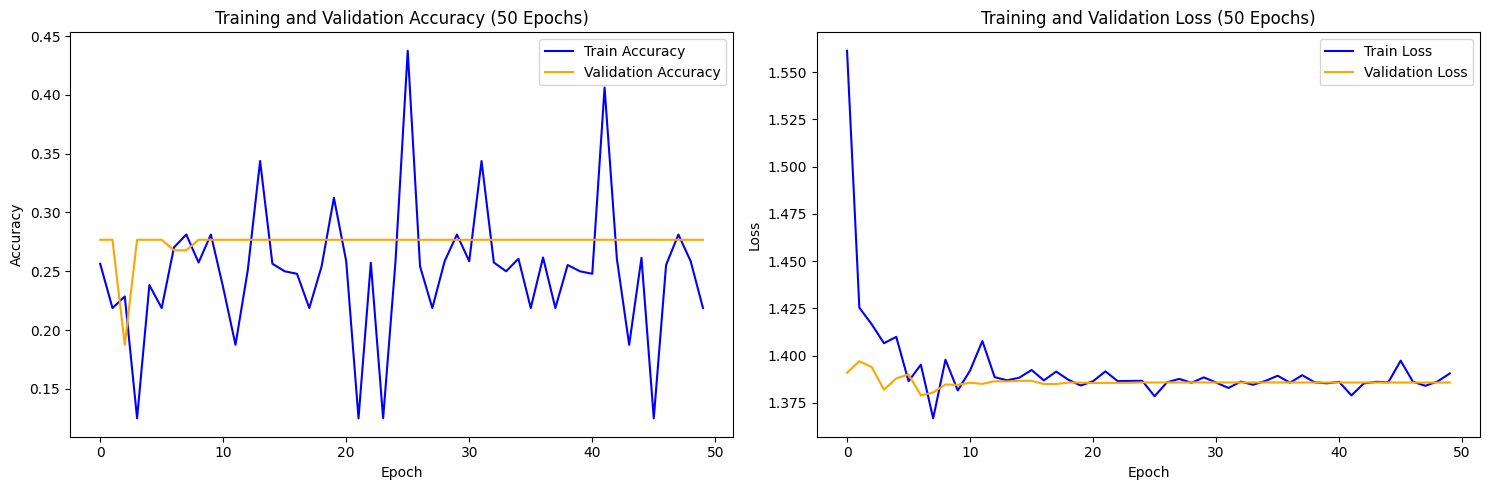


Final Training Accuracy: 0.2188
Final Validation Accuracy: 0.2768
Final Training Loss: 1.3906
Final Validation Loss: 1.3858


In [7]:
# Plot akurasi dan loss training dan validation
plt.figure(figsize=(15, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy (50 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss (50 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Menampilkan nilai akhir
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'\nFinal Training Accuracy: {final_train_acc:.4f}')
print(f'Final Validation Accuracy: {final_val_acc:.4f}')
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.5849 - loss: 1.3723

Test Accuracy: 0.2562
Test Loss: 1.3861
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step

Classification Report:
              precision    recall  f1-score   support

      Cutter       0.26      1.00      0.41       310
  Pen_Cutter       0.00      0.00      0.00       300
 Pisau Dapur       0.00      0.00      0.00       300
Pisau_Daging       0.00      0.00      0.00       300

    accuracy                           0.26      1210
   macro avg       0.06      0.25      0.10      1210
weighted avg       0.07      0.26      0.10      1210



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


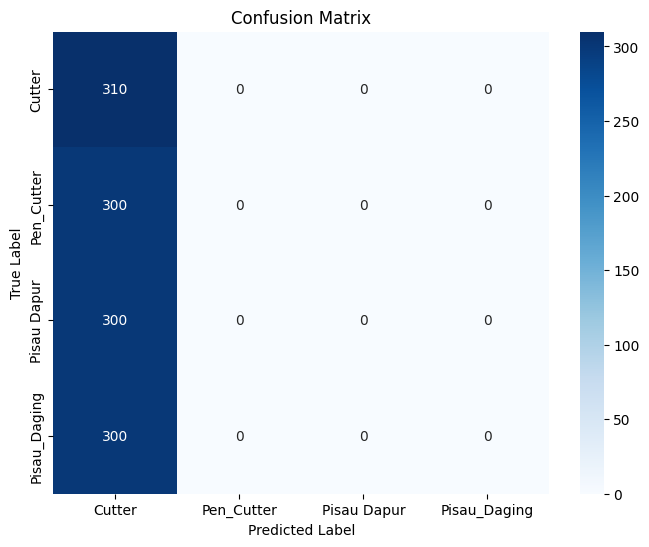

In [10]:
# Evaluasi model pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Prediksi pada test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
from google.colab import files
from tensorflow.keras.preprocessing import image

def predict_new_image(model, class_names):
    # Upload gambar dari lokal
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Load dan preprocess gambar
        img_path = '/content/' + filename
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalisasi seperti pada training

        # Tampilkan gambar
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Prediksi
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])

        # Tampilkan hasil
        print(f"\nGambar: {filename}")
        print(f"Prediksi: {class_names[predicted_class]}")
        print(f"Confidence: {confidence:.2%}")
        print("\nProbabilitas per kelas:")
        for i, (class_name, prob) in enumerate(zip(class_names, predictions[0])):
            print(f"{class_name}: {prob:.4f}")

# Mendapatkan nama kelas dari generator
class_names = list(train_generator.class_indices.keys())

# Memanggil fungsi prediksi
print("Silakan upload gambar untuk diprediksi...")
predict_new_image(model, class_names)

Silakan upload gambar untuk diprediksi...


KeyboardInterrupt: 